# Training and Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.preprocessing import StandardScaler,  LabelEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
df = pd.read_csv("df_encoded.csv")

In [3]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency_-1.0,histogram_tendency_0.0,histogram_tendency_1.0,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,2.0,0.0,120.0,137.0,121.0,73.0,0.0,0.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,0.0,0.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,0.0,0.0,1.0,1.0


Before we begin training the prototype model, we'll change the target feature into integers. For reference, <br>
- 1: Normal
- 2: Suspect
- 3: Pathological

In [4]:
# Convert the target column into an integer and check if it worked
df['fetal_health']= df['fetal_health'].astype(int)
df['fetal_health'].dtype

dtype('int64')

There are no redudnant columns either, so we can move straight into training a baseline model. I'll be using a random forest as the baseline. Since the prototype, I've added the 'class_weight' parameter to account for the class imbalance by giving more weight to the minority classes, and this increased both the macro average F1-score and class metrics for all classes.

Random Forest Classification Report
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97       332
     Suspect       0.89      0.71      0.79        59
Pathological       0.91      0.89      0.90        35

    accuracy                           0.94       426
   macro avg       0.92      0.86      0.89       426
weighted avg       0.94      0.94      0.94       426



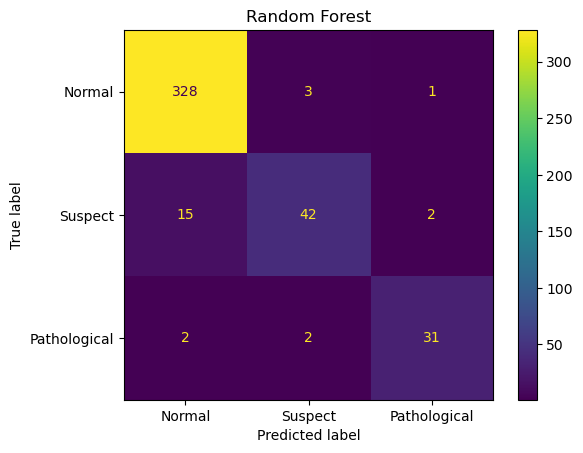

In [5]:
# Define evaluation functions
target_names = ["Normal", "Suspect", "Pathological"]

def class_metrics(actual, pred, labels, model_name):
    print(f"{model_name} Classification Report")
    print(classification_report(actual, pred, target_names=labels))
    
def display_matrix(actual, pred, labels, model_name):
    cm = confusion_matrix(actual, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    ax = disp.plot().ax_
    ax.set_title(model_name)
    plt.show()
    
# Define the X and y variables
X = df.drop(["fetal_health"], axis=1)
y = df['fetal_health']

# Split into training and test sets, making sure to stratify since there's an imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create and train the random forest classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Run evaluations
class_metrics(y_test, y_pred, target_names, "Random Forest")
display_matrix(y_test, y_pred, target_names, "Random Forest")

Let's try a different model, like XGBoost. It can handle multiclass classification well and has built in parameters to account for class imbalances. But first, we have to label encode the target variable.

So the new labels will be

- 0 = Normal
- 1 = Suspect
- 2 = Pathological

In [6]:
# Create a copy of the dataframe
df_xgb = df.copy()

# Initialize label encoder
le = LabelEncoder()

# Fit and transform the outcome column
df_xgb['fetal_health'] = le.fit_transform(df_xgb['fetal_health'])

# Check the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{1: 0, 2: 1, 3: 2}


In [7]:
df_xgb.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency_-1.0,histogram_tendency_0.0,histogram_tendency_1.0,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,2.0,0.0,120.0,137.0,121.0,73.0,0.0,0.0,1.0,1
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,0.0,0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,0.0,0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,0.0,0.0,1.0,0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,0.0,0.0,1.0,0


Now, we can train the XGBoost model. I'll also be calculating the sample weights for each class and putting it into the model so that the minority classes can be more heavily weighted in training. 

Although the macro average F1-score is the same, the recall of the suspect class has increased from 0.71 to 0.78. The recall of the pathological class also increased slightly from 0.89 to 0.91. The confusion matrix reflects this, however, the normal class got slightly worse with mislabeling. I believe this is an acceptable trade off for prioritizing recall and F1-score of the suspect class. Given this, I'll be choosing XGBoost as my main model going forward.

XGBoost Classification Report
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97       332
     Suspect       0.85      0.78      0.81        59
Pathological       0.86      0.91      0.89        35

    accuracy                           0.94       426
   macro avg       0.89      0.89      0.89       426
weighted avg       0.94      0.94      0.94       426



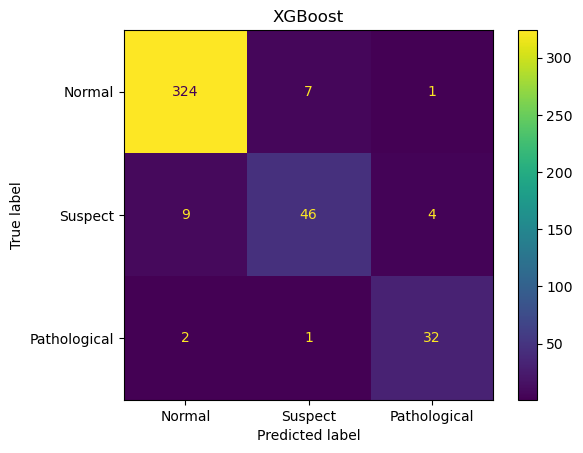

In [8]:
# Define the X and y variables
X_xgb = df_xgb.drop(["fetal_health"], axis=1)
y_xgb = df_xgb['fetal_health']

# Split into training and validation sets, making sure to stratify since there's an imbalance
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, 
                                                                    stratify=y_xgb, random_state=42)

# Compute sample weights for each class
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_xgb)

# Fit and train an XGBoost model
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
xgb.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weights)
y_pred_xgb = xgb.predict(X_test_xgb)

# Run evaluations
class_metrics(y_test_xgb, y_pred_xgb, target_names, "XGBoost")
display_matrix(y_test_xgb, y_pred_xgb, target_names, "XGBoost")

Another strategy to increase the suspect and pathological class metrics is by artifically creating more samples of these classes before training. I'll implement and compare two of these strategies: SMOTE (generating new data for the class using interpolation) and Random Oversampling (duplicating existing datapoints in the class). I will also remove the 'sample_weight' parameter to avoid overfitting.

XGBoost with Random Oversampling Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       332
     Suspect       0.87      0.76      0.81        59
Pathological       0.89      0.91      0.90        35

    accuracy                           0.94       426
   macro avg       0.91      0.89      0.89       426
weighted avg       0.94      0.94      0.94       426



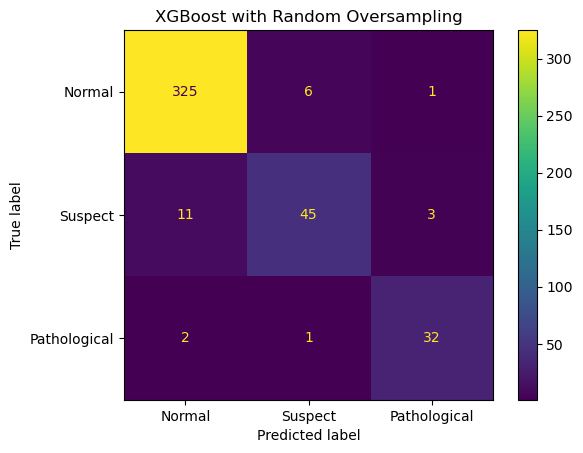

In [9]:
# Split the data
X_train, X_test_ros, y_train, y_test_ros = train_test_split(X_xgb, y_xgb, test_size=0.2, stratify=y_xgb, random_state=42)

# Over sample in only the training data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Fit and train a XGBoost model
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
xgb.fit(X_train_ros, y_train_ros)
y_pred_ros = xgb.predict(X_test_ros)

# Run evaluations
class_metrics(y_test_ros, y_pred_ros, target_names, "XGBoost with Random Oversampling")
display_matrix(y_test_ros, y_pred_ros, target_names, "XGBoost with Random Oversampling")

Looking at the confusion matrix and class report, the suspect class actually performed slightly worse, so let's move onto SMOTE.

XGBoost with SMOTE Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96       332
     Suspect       0.84      0.78      0.81        59
Pathological       0.86      0.86      0.86        35

    accuracy                           0.93       426
   macro avg       0.88      0.87      0.88       426
weighted avg       0.93      0.93      0.93       426



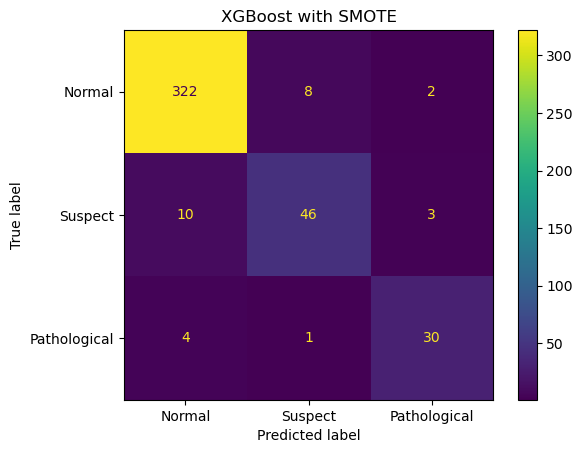

In [10]:
# Split the data
X_train, X_test_smote, y_train, y_test_smote = train_test_split(X_xgb, y_xgb, test_size=0.2, stratify=y_xgb, random_state=42)

# Run SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# fit and train a XGBoost model
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
xgb.fit(X_train_smote, y_train_smote)
y_pred_smote = xgb.predict(X_test_smote)

# Run evaluations
class_metrics(y_test_smote, y_pred_smote, target_names, "XGBoost with SMOTE")
display_matrix(y_test_smote, y_pred_smote, target_names, "XGBoost with SMOTE")

This strategy also led to slightly lower metrics, so we'll just stick with the original XGBoost model with the sample_weights added. Now, moving onto hyperparameter tuning. Since we have a severely imbalanced dataset, I'll be using Macro-averaged F1-score as the main metric for comparing model accuracy. 

In [11]:
# Create a set of hyperparameters and range of values
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [3, 5, 7],            # Depth of the trees
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage to prevent overfitting
    'max_delta_step': [1,3,5],         # Can help stop bias against majority class
    'gamma': [0.1,0.3,0.5]             # Minimum loss reduction to make a split
}

# Ensure each fold has the same class proportions as the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model and apply Grid Search
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
grid_xgb = GridSearchCV(xgb, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
grid_xgb.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weights)

# Print best paramaters and best macro F1 score
print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best XGBoost Score:", grid_xgb.best_score_)

Best XGBoost Params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_delta_step': 1, 'max_depth': 7, 'n_estimators': 100}
Best XGBoost Score: 0.925025881224896


Now, let's see how the model performs with these optimized hyperparameters on the test set.

Optimized XGBoost Classification Report
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       332
     Suspect       0.88      0.83      0.85        59
Pathological       0.87      0.94      0.90        35

    accuracy                           0.96       426
   macro avg       0.91      0.92      0.91       426
weighted avg       0.96      0.96      0.96       426



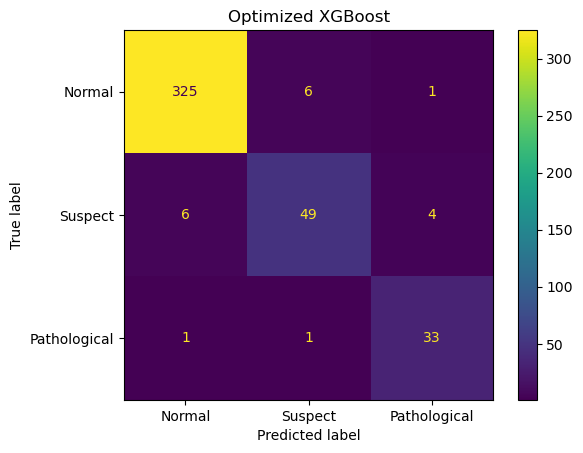

In [12]:
# Initialize the optimized model
final_xgb = XGBClassifier(objective='multi:softmax', 
                          random_state=42, 
                          gamma=0.1, 
                          learning_rate=0.2, 
                          max_delta_step=1, 
                          max_depth=7, 
                          n_estimators=100)

# Fit the model
final_xgb.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weights)

# Create the predictions
y_pred_final = final_xgb.predict(X_test_xgb)

# Evaluate the model
class_metrics(y_test_xgb, y_pred_final, target_names, "Optimized XGBoost")
display_matrix(y_test_xgb, y_pred_final, target_names, "Optimized XGBoost")

This is an excellent result! Now, we'll just gather all of the scores for the models we did into a neat table.

In [13]:
# Create and display table of scores
table = [
    ["Baseline Random Forest with Sample Weights", round(f1_score(y_test, y_pred, average="macro"), 3)],
    ["Baseline XGBoost", round(f1_score(y_test_xgb, y_pred_xgb, average="macro"), 3)],
    ["XGBoost with Random Oversampling", round(f1_score(y_test_ros, y_pred_ros, average="macro"), 3)],
    ["XGBoost with SMOTE", round(f1_score(y_test_smote, y_pred_smote, average="macro"), 3)],
    ["XGBoost with Optimized Hyperparameters", round(f1_score(y_test_xgb, y_pred_final, average="macro"), 3)]
]

display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model Iteration", "Macro-Averaged F1-Score"])))

Model Iteration,Macro-Averaged F1-Score
Baseline Random Forest with Sample Weights,0.887
Baseline XGBoost,0.892
XGBoost with Random Oversampling,0.894
XGBoost with SMOTE,0.876
XGBoost with Optimized Hyperparameters,0.912
